In [1]:
import os
import string
import numpy as np
import pandas as pd
import re
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import xgboost as xgb
from sklearn import metrics
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('sentiwordnet')
from textblob import TextBlob

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sneharawat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sneharawat/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/sneharawat/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [2]:
train = pd.read_csv("train_file.csv")
train = train.drop(['IDLink', 'Source', 'PublishDate', 'Facebook', 'GooglePlus', 'LinkedIn'], axis=1)
train.head()

,Title,Headline,Topic,SentimentTitle,SentimentHeadline
0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,obama,0.000000,-0.053300
1,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",economy,0.208333,-0.156386
2,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",economy,-0.425210,0.139754
3,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,economy,0.000000,0.026064
4,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,economy,0.000000,0.141084


In [3]:
sia = SIA()
results = []

In [4]:
for line in train['Title']:
    pol_score = sia.polarity_scores(line)
    pol_score['Title'] = line
    pol_score['subjectivity'] = TextBlob(line).subjectivity
    pol_score['polarity'] = TextBlob(line).polarity
    results.append(pol_score)
    
print(results[:5])

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0, 'Title': 'Obama Lays Wreath at Arlington National Cemetery', 'subjectivity': 0.0, 'polarity': 0.0}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0, 'Title': 'A Look at the Health of the Chinese Economy', 'subjectivity': 0.0, 'polarity': 0.0}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0, 'Title': 'Nouriel Roubini: Global Economy Not Back to 2008', 'subjectivity': 0.0, 'polarity': 0.0}, {'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'compound': 0.1027, 'Title': 'Finland GDP Expands In Q4', 'subjectivity': 0.0, 'polarity': 0.0}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0, 'Title': 'Tourism, govt spending buoys Thai economy in January', 'subjectivity': 0.0, 'polarity': 0.0}]


In [5]:
results1 = []
for line in train['Headline']:
    pol_score = sia.polarity_scores(line)
    pol_score['Headline'] = line
    pol_score['subjectivity'] = TextBlob(line).subjectivity
    pol_score['polarity'] = TextBlob(line).polarity
    results1.append(pol_score)

print(results1[:5])

[{'neg': 0.0, 'neu': 0.862, 'pos': 0.138, 'compound': 0.4939, 'Headline': 'Obama Lays Wreath at Arlington National Cemetery. President Barack Obama has laid a wreath at the Tomb of the Unknowns to honor', 'subjectivity': 0.0, 'polarity': 0.0}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0, 'Headline': 'Tim Haywood, investment director business-unit head for fixed income at Gam, discusses the China beige book and the state of the economy.', 'subjectivity': 0.2, 'polarity': 0.1}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0, 'Headline': "Nouriel Roubini, NYU professor and chairman at Roubini Global Economics, explains why the global economy isn't facing the same conditions", 'subjectivity': 0.041666666666666664, 'polarity': 0.0}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0, 'Headline': "Finland's economy expanded marginally in the three months ended December, after contracting in the previous quarter, preliminary figures from Statistics Finland showed Monday. ", '

In [6]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
train["topic"] = lb_make.fit_transform(train["Topic"])
train[["topic", "Topic"]].head(11)

title = pd.DataFrame.from_records(results)
title = title[['Title', 'neg', 'neu', 'pos', 'compound', 'polarity', 'subjectivity']]
title['SentimentTitle'] = train['SentimentTitle']
title['topic'] = train['topic']
title = pd.DataFrame(title)
title.head()
corr = title.corr()
corr.style.background_gradient(cmap='coolwarm')

,neg,neu,pos,compound,polarity,subjectivity,SentimentTitle,topic
neg,1,-0.642386,-0.186232,-0.752905,-0.223988,0.0671892,-0.194299,0.0639255
neu,-0.642386,1,-0.633341,0.0188709,-0.0433878,-0.171887,0.0615421,-0.000303605
pos,-0.186232,-0.633341,1,0.73607,0.281805,0.152515,0.117301,-0.0641613
compound,-0.752905,0.0188709,0.73607,1,0.346849,0.0604022,0.209606,-0.0848954
polarity,-0.223988,-0.0433878,0.281805,0.346849,1,0.204283,0.139547,-0.0390763
subjectivity,0.0671892,-0.171887,0.152515,0.0604022,0.204283,1,-0.0429913,-0.0556063
SentimentTitle,-0.194299,0.0615421,0.117301,0.209606,0.139547,-0.0429913,1,0.00806946
topic,0.0639255,-0.000303605,-0.0641613,-0.0848954,-0.0390763,-0.0556063,0.00806946,1


In [7]:
headline = pd.DataFrame.from_records(results1)
headline = headline[['Headline', 'neg', 'neu', 'pos', 'compound', 'polarity', 'subjectivity']]
headline['SentimentHeadline'] = train['SentimentHeadline']
headline['topic'] = train['topic']
headline = pd.DataFrame(headline)
headline.head()
corr = headline.corr()
corr.style.background_gradient(cmap='coolwarm')

,neg,neu,pos,compound,polarity,subjectivity,SentimentHeadline,topic
neg,1,-0.613296,-0.160726,-0.719672,-0.210952,0.0354503,-0.190763,0.0564953
neu,-0.613296,1,-0.680125,-0.0445591,-0.0528537,-0.150244,0.0479255,0.00400591
pos,-0.160726,-0.680125,1,0.723581,0.261898,0.155281,0.117023,-0.0573923
compound,-0.719672,-0.0445591,0.723581,1,0.310401,0.0876221,0.204027,-0.0733436
polarity,-0.210952,-0.0528537,0.261898,0.310401,1,0.255247,0.15626,-0.0585607
subjectivity,0.0354503,-0.150244,0.155281,0.0876221,0.255247,1,-0.00854849,-0.0488379
SentimentHeadline,-0.190763,0.0479255,0.117023,0.204027,0.15626,-0.00854849,1,0.0259325
topic,0.0564953,0.00400591,-0.0573923,-0.0733436,-0.0585607,-0.0488379,0.0259325,1


In [8]:
X = title.drop(['Title', 'SentimentTitle'], axis=1)
Y = title['SentimentTitle']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [9]:
X1 = headline.drop(['Headline', 'SentimentHeadline'], axis=1)
Y1 = headline['SentimentHeadline']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=0)

In [10]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 400, random_state = 0)
regressor.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=400,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [11]:
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.08861865646766545
Mean Squared Error: 0.01556778170149643
Root Mean Squared Error: 0.12477091688970002


In [12]:
regressor1 = xgb.XGBRegressor()
regressor1.fit(X1_train,y1_train)

y1_pred = regressor1.predict(X1_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y1_test, y1_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y1_test, y1_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y1_test, y1_pred)))

Mean Absolute Error: 0.10662787185132733
Mean Squared Error: 0.019304815503771576
Root Mean Squared Error: 0.13894177019086656


In [13]:
test = pd.read_csv("test_file.csv")
test = test.drop(['IDLink', 'Source', 'PublishDate', 'Facebook', 'GooglePlus', 'LinkedIn'], axis=1)
test.head()

,Title,Headline,Topic
0,Sliding Economy: FG fights back with N3trn TSA...,With the 2016 budget now passed by the Nationa...,economy
1,Microsoft shows how HoloLens can bring distant...,A recent Microsoft Research video shows how th...,microsoft
2,"Microsoft’s Twitter Robot Praises Hitler, Trum...",* Microsoft teamed with Bing to create TayTwee...,microsoft
3,Flood of Central Bank Moves Can't Get World Ec...,Central bankers have managed to steer the worl...,economy
4,USD/JPY: bears lining up on mixed U.S. economy...,"However, this streak of seven-day gains might ...",economy


In [14]:
lb_make = LabelEncoder()
test["topic"] = lb_make.fit_transform(test["Topic"])
test[["topic", "Topic"]].head(11)

,topic,Topic
0,0,economy
1,1,microsoft
2,1,microsoft
3,0,economy
4,0,economy
5,2,obama
6,2,obama
7,2,obama
8,2,obama
9,0,economy


In [15]:
sia = SIA()
results = []

for line in test['Title']:
    pol_score = sia.polarity_scores(line)
    pol_score['Title'] = line
    pol_score['subjectivity'] = TextBlob(line).subjectivity
    pol_score['polarity'] = TextBlob(line).polarity
    results.append(pol_score)

print(results[:5])

[{'neg': 0.252, 'neu': 0.748, 'pos': 0.0, 'compound': -0.4019, 'Title': 'Sliding Economy: FG fights back with N3trn TSA funds', 'subjectivity': 0.0, 'polarity': 0.0}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0, 'Title': 'Microsoft shows how HoloLens can bring distant family members ...', 'subjectivity': 0.35, 'polarity': -0.1}, {'neg': 0.304, 'neu': 0.444, 'pos': 0.252, 'compound': -0.1779, 'Title': 'Microsoft’s Twitter Robot Praises Hitler, Trump & Recites Racism', 'subjectivity': 0.0, 'polarity': 0.0}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0, 'Title': "Flood of Central Bank Moves Can't Get World Economy Out of Rut", 'subjectivity': 0.25, 'polarity': 0.0}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0, 'Title': 'USD/JPY: bears lining up on mixed U.S. economy outlook', 'subjectivity': 0.25, 'polarity': 0.0}]


In [16]:
sia = SIA()
results1 = []

for line in test['Headline']:
    pol_score = sia.polarity_scores(line)
    pol_score['Headline'] = line
    pol_score['subjectivity'] = TextBlob(line).subjectivity
    pol_score['polarity'] = TextBlob(line).polarity
    results1.append(pol_score)

print(results1[:5])

[{'neg': 0.163, 'neu': 0.837, 'pos': 0.0, 'compound': -0.5994, 'Headline': 'With the 2016 budget now passed by the National Assembly and a N3trillion war chest, the government of President Muhammadu Buhari says', 'subjectivity': 0.0, 'polarity': 0.0}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0, 'Headline': 'A recent Microsoft Research video shows how the $3000 augmented reality system can be used to transmit 3D models of people anywhere in', 'subjectivity': 0.25, 'polarity': 0.0}, {'neg': 0.083, 'neu': 0.805, 'pos': 0.112, 'compound': -0.0, 'Headline': '* Microsoft teamed with Bing to create TayTweets, an account for a robot that was designed to learn about “conversational understanding,” by having automated discussions with Twitter users, and mimicking the language they use. TayTweets started out harmless, but in less than 24 hours, the bot descended down the dark hole of racism — before it … Continue reading Microsoft’s Twitter Robot Praises ', 'subjectivity': 0.25185185185

In [17]:
title = pd.DataFrame.from_records(results)
title = title[['Title', 'neg', 'neu', 'pos', 'compound', 'polarity', 'subjectivity']]
title['topic'] = test['topic']
title = pd.DataFrame(title)
title.head()

,Title,neg,neu,pos,compound,polarity,subjectivity,topic
0,Sliding Economy: FG fights back with N3trn TSA...,0.252,0.748,0.000,-0.4019,0.0,0.00,0
1,Microsoft shows how HoloLens can bring distant...,0.000,1.000,0.000,0.0000,-0.1,0.35,1
2,"Microsoft’s Twitter Robot Praises Hitler, Trum...",0.304,0.444,0.252,-0.1779,0.0,0.00,1
3,Flood of Central Bank Moves Can't Get World Ec...,0.000,1.000,0.000,0.0000,0.0,0.25,0
4,USD/JPY: bears lining up on mixed U.S. economy...,0.000,1.000,0.000,0.0000,0.0,0.25,0


In [18]:
headline = pd.DataFrame.from_records(results1)
headline = headline[['Headline', 'neg', 'neu', 'pos', 'compound', 'polarity', 'subjectivity']]
headline['topic'] = test['topic']
headline = pd.DataFrame(headline)
headline.head()

,Headline,neg,neu,pos,compound,polarity,subjectivity,topic
0,With the 2016 budget now passed by the Nationa...,0.163,0.837,0.000,-0.5994,0.000000,0.000000,0
1,A recent Microsoft Research video shows how th...,0.000,1.000,0.000,0.0000,0.000000,0.250000,1
2,* Microsoft teamed with Bing to create TayTwee...,0.083,0.805,0.112,-0.0000,-0.157407,0.251852,1
3,Central bankers have managed to steer the worl...,0.220,0.706,0.073,-0.6369,0.087500,0.272917,0
4,"However, this streak of seven-day gains might ...",0.000,0.807,0.193,0.6705,0.000000,0.000000,0


In [19]:
X = title.drop(['Title'], axis=1)
result = regressor.predict(X)
print(result)

[-0.11854616  0.09713534 -0.04197113 ... -0.05100818  0.2056922
 -0.00163624]


In [20]:
X1 = headline.drop(['Headline'], axis=1)
result1 = regressor1.predict(X1)
print(result1)

[-0.06627917 -0.02736396 -0.05742216 ... -0.05239636  0.03147092
 -0.03282022]


In [21]:
test = pd.read_csv("test_file.csv")
final = pd.DataFrame()
final['IDLink'] = test['IDLink']
final['SentimentTitle'] = result
final['SentimentHeadline'] = result1
final.to_csv('output.csv',index=False)

In [22]:
feature_importances = pd.DataFrame(regressor.feature_importances_,index = X_train.columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances1 = pd.DataFrame(regressor1.feature_importances_,index = X1_train.columns,columns=['importance']).sort_values('importance',ascending=False)

In [23]:
feature_importances

,importance
compound,0.267667
neu,0.146762
subjectivity,0.145405
polarity,0.138984
neg,0.106122
pos,0.099332
topic,0.095728


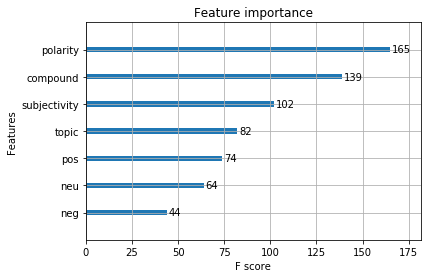

In [24]:
xgb.plot_importance(regressor1)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [25]:
feature_importances1

,importance
polarity,0.246269
compound,0.207463
subjectivity,0.152239
topic,0.122388
pos,0.110448
neu,0.095522
neg,0.065672
